In [1]:
#install dependency
# Install necessary packages with TensorFlow version 2.15.1
!pip install pandas numpy tensorflow==2.15.1 scikit-learn keras skforecast seaborn matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 560.6/560.6 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [2]:
!pip install skforecast

# LSTM for modeling Business As Usual Condition

For simple implementation, I use a package calls skforecast, which helps with converting time series to supervised learning problem and configuring model architecture.
Following steps:
1. Bayesian Optimization to determine which number of lags is appropriate, as well as number of densed layers, hidden layers, recurrent units.
2. Train the model.
3. Backtesting to evaluate model's performance on test data. The test time window is determined as from 15-11-2023 to 08.01.2024 ( 1 day before the first GDL strike)
4. Run the model to find the prediction at the time window where the strike were on effect ( 10-01-2024 to 15-03-2024)
5. Calculate the mean difference and the mean percentage difference between the real observation and the 'predicted value' aka the business as usual values.

In [3]:
#import necessary packages

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


from skforecast.ForecasterRnn import ForecasterRnn
from skforecast.ForecasterRnn.utils import create_and_compile_model
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter


In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
from google.colab import files
uploaded = files.upload()


Saving chor_training_data.csv to chor_training_data.csv
Saving cle_training_data.csv to cle_training_data.csv
Saving rod_training_data.csv to rod_training_data.csv
Saving turi_training_data.csv to turi_training_data.csv


In [6]:
# load data
chor_training = pd.read_csv('chor_training_data.csv')
cle_training = pd.read_csv('cle_training_data.csv')
turi_training = pd.read_csv('turi_training_data.csv')
rod_training = pd.read_csv('rod_training_data.csv')



In [7]:
chor_training['Date'] = pd.to_datetime(chor_training['Date'])
cle_training['Date'] = pd.to_datetime(cle_training['Date'])
turi_training['Date'] = pd.to_datetime(turi_training['Date'])
rod_training['Date'] = pd.to_datetime(rod_training['Date'])


chor_training = chor_training.set_index('Date')
cle_training = cle_training.set_index('Date')
turi_training = turi_training.set_index('Date')
rod_training = rod_training.set_index('Date')


chor_training.index = pd.to_datetime(chor_training.index)
cle_training.index = pd.to_datetime(cle_training.index)
turi_training.index = pd.to_datetime(turi_training.index)
rod_training.index = pd.to_datetime(rod_training.index)


In [8]:
# fill missing values by interpolation
chor_training = chor_training.interpolate(method='linear')
cle_training = cle_training.interpolate(method='linear')
turi_training = turi_training.interpolate(method='linear')
rod_training = rod_training.interpolate(method='linear')




In [9]:
#drop duplicates index
chor_training = chor_training[~chor_training.index.duplicated()]
cle_training = cle_training[~cle_training.index.duplicated()]
turi_training = turi_training[~turi_training.index.duplicated()]
rod_training = rod_training[~rod_training.index.duplicated()]



In [10]:
chor_training['AQI'] = chor_training['AQI'].ffill()
cle_training['AQI'] = cle_training['AQI'].ffill()
turi_training['AQI'] = turi_training['AQI'].ffill()
rod_training['AQI'] = rod_training['AQI'].ffill()


In [11]:
AQI_chor = chor_training['AQI']
AQI_cle = cle_training['AQI']
AQI_turi = turi_training['AQI']
AQI_rod = rod_training['AQI']

#drop AQI column
chor_training = chor_training.drop(columns=['AQI','Stationscode'])
cle_training = cle_training.drop(columns=['AQI','Stationscode'])
turi_training = turi_training.drop(columns=['AQI','Stationscode'])
rod_training = rod_training.drop(columns=['AQI','Stationscode'])





In [12]:
chor_training = chor_training.resample('H').mean()
cle_training = cle_training.resample('H').mean()
turi_training = turi_training.resample('H').mean()
rod_training = rod_training.resample('H').mean()


In [13]:
chor_training = chor_training.interpolate(method='linear')
cle_training = cle_training.interpolate(method='linear')
turi_training = turi_training.interpolate(method='linear')
rod_training = rod_training.interpolate(method='linear')

In [ ]:
chor_training= chor_training.dropna()

In [14]:
rod_training.interpolate(method='linear')
rod_training = rod_training.resample('H').mean()
rod_training.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19705 entries, 2022-01-01 01:00:00 to 2024-04-01 01:00:00
Freq: H
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PM_10          19705 non-null  float64
 1   NO2            19705 non-null  float64
 2   PM_2.5         11617 non-null  float64
 3   Humidity       19705 non-null  float64
 4   NO             19705 non-null  float64
 5   O3             19705 non-null  float64
 6   Temperature    19705 non-null  float64
 7   Windspeed      19705 non-null  float64
 8   WindDirection  19705 non-null  float64
 9   Precipitation  19705 non-null  float64
dtypes: float64(10)
memory usage: 1.7 MB


### Train-validation-test split

In [15]:
def train_test_split_evaluation(data):
    end_train = '2023-07-01 00:00:00'
    end_validation ='2023-11-01 00:00:00'
    end_test = '2024-01-05 00:00:00'
    data = data.loc[data.index <= end_test].copy()
    data_train = data.loc[data.index <= end_train].copy()
    data_validation = data.loc[(data.index > end_train) & (data.index <= end_validation)].copy()
    data_test = data.loc[(data.index > end_validation) & (data.index <= end_test)].copy()
    return data, data_train, data_validation, data_test


In [16]:
def train_test_split_effect_measure(data):
    end_train = '2023-11-15 00:00:00'
    end_val = '2024-01-09 00:00:00'
    end_test = '2024-03-15 00:00:00'
    data = data.loc[data.index <= end_test].copy()
    data_train = data.loc[data.index <= end_train].copy()
    data_val = data.loc[(data.index > end_train) & (data.index <= end_val)].copy()
    data_test = data.loc[(data.index > end_val) & (data.index <= end_test)].copy()
    return data, data_train, data_val, data_test

### Define models

In [71]:
from sklearn.preprocessing import MinMaxScaler


def build_model(data, series, lags, steps,epochs, batch_size,is_train):
    if is_train:
        data_final, data_train, data_val, data_test =train_test_split_evaluation(data)
    else:
        data_final, data_train, data_val, data_test =train_test_split_effect_measure(data)



    data_final = data_final[series]
    train = data_train[series]
    val = data_val[series]
    test = data_test[series]

    series = series
    levels = series[0]
    steps = steps
    lags = lags

    model = create_and_compile_model(
        series=train,
    levels=levels,
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=[100, 50],
    dense_units=[lags*2, lags],
    activation="tanh",
    optimizer=Adam(learning_rate=0.01),
    loss=MeanSquaredError()
)
    forecaster = ForecasterRnn(
        regressor=model,

    levels=levels,
    steps=steps,
    lags=lags,
    transformer_series=MinMaxScaler(),

    fit_kwargs={
        "epochs": epochs,
        "batch_size": batch_size,
        "series_val": val,

    },


    )
    return model,forecaster,data_final, train,val,test




In [18]:
def train_model(forecaster,train,steps):
    forecaster.fit(train)
    preds = forecaster.predict(steps=steps)
    return forecaster,preds

In [19]:
def backtesting_evaluation(forecaster,data, end_val):


    metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.max_step,
    series=data,
    levels=forecaster.levels,
    initial_train_size=len(data.loc[:end_val, :]),
    metric="mean_absolute_error",
    verbose=False,
    refit=False,
)


    return metrics, predictions

In [20]:
def metrics_and_plot(predictions, test):
    metrics = mean_squared_error(test, predictions)
    r2 = r2_score(test, predictions)
    rmse = mean_squared_error(test, predictions, squared=False)
    mape = np.mean(np.abs((test - predictions) / test)) * 100
    plt.figure(figsize=(10, 6))
    plt.plot(test, label='True')
    plt.plot(predictions, label='Predicted')
    plt.legend()
    plt.show()

    print(f'MSE: {metrics}')
    print(f'R2: {r2}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}')


### Calculate Effects

In [89]:


def effect_measure(predictions, data_test, pollutant):
    # Define strike data
    strike_period_1 = pd.date_range(start='2024-02-02 03:00', end='2024-02-03 03:00', freq='H')
    strike_period_2 = pd.date_range(start='2024-02-15 03:00', end='2024-02-16 03:00', freq='H')
    strike_period_3 = pd.date_range(start='2024-02-29 03:00', end='2024-03-02 03:00', freq='H')
    strike_period_4 = pd.date_range(start='2024-03-05 03:00', end='2024-03-07 03:00', freq='H')

    all_strike_periods = strike_period_1.append(strike_period_2).append(strike_period_3).append(strike_period_4)

    strike_GDL_period_1 = pd.date_range(start='2024-01-10 02:00', end='2024-01-12 18:00', freq='H')
    strike_GDL_period_2 = pd.date_range(start='2024-01-24 02:00', end='2024-01-29 18:00', freq='H')
    strike_GDL_period_3 = pd.date_range(start='2024-03-12 02:00', end='2024-03-13 02:00', freq='H')

    strike_GDL = strike_GDL_period_1.append(strike_GDL_period_2).append(strike_GDL_period_3)

    # Calculate strike predictions and real observations
    strike_predictions = predictions.loc[all_strike_periods].copy()
    strike_real = data_test.loc[all_strike_periods].copy()

    # Mean difference and percent difference for all strike periods
    mean_diff = np.mean(strike_predictions[pollutant] - strike_real[pollutant])
    mean_percent_diff = np.mean(np.abs(strike_predictions[pollutant] - strike_real[pollutant]) /
                                 strike_predictions[pollutant] )* 100




    print(f'Mean difference between strike prediction and real observation: {mean_diff}')
    print(f'Mean percent difference between strike prediction and real observation: {mean_percent_diff}')


    # Calculate GDL strike predictions and real observations
    strike_GDL_predictions = predictions.loc[strike_GDL].copy()
    strike_real_GDL = data_test.loc[strike_GDL].copy()

    # Mean difference and percent difference for GDL strike periods
    mean_diff_GDL = np.mean(strike_GDL_predictions[pollutant] - strike_real_GDL[pollutant])
    mean_percent_diff_GDL = np.mean(np.abs(strike_GDL_predictions[pollutant] - strike_real_GDL[pollutant]) /
                                    ((strike_GDL_predictions[pollutant])) )* 100

    print(f'Mean difference between strike prediction and real observation GDL: {mean_diff_GDL}')
    print(f'Mean percent difference between strike prediction and real observation GDL: {mean_percent_diff_GDL}')



### PM10

#### Chorweiler

In [ ]:
chor_training.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19704 entries, 2022-01-01 02:00:00 to 2024-04-01 01:00:00
Freq: H
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PM_10          19704 non-null  float64
 1   O3             19704 non-null  float64
 2   NO2            19704 non-null  float64
 3   Humidity       19704 non-null  float64
 4   NO             19704 non-null  float64
 5   Temperature    19704 non-null  float64
 6   Windspeed      19704 non-null  float64
 7   WindDirection  19704 non-null  float64
 8   Precipitation  19704 non-null  float64
dtypes: float64(9)
memory usage: 1.5 MB


In [72]:
series = ['PM_10','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 240
steps = 24

model_chor_pm10, forecaster_chor_pm10,data_chor, train_chor_pm10,val_chor_pm10,test_chor_pm10 = build_model(chor_training, series, lags, steps, 4, 128,True)

In [ ]:
model_chor_pm10.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 6)]          0         
                                                                 
 lstm (LSTM)                 (None, 240, 100)          42800     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 480)               24480     
                                                                 
 dense_1 (Dense)             (None, 240)               115440    
                                                                 
 dense_2 (Dense)             (None, 24)                5784      
                                                                 
 reshape (Reshape)           (None, 24, 1)             0     

In [ ]:
forecaster_chor_pm10

ForecasterRnn 
Regressor: <keras.src.engine.functional.Functional object at 0x000001FF9B502800> 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 

In [73]:
forecaster_chor_pm10, preds_chor_pm10 = train_model(forecaster_chor_pm10,train_chor_pm10,5)

Epoch 1/4
103/103 [==============================] - 5s 16ms/step - loss: 0.0129 - val_loss: 0.0022
Epoch 2/4
103/103 [==============================] - 1s 9ms/step - loss: 9.1599e-04 - val_loss: 0.0082
Epoch 3/4
103/103 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 4/4
103/103 [==============================] - 1s 9ms/step - loss: 6.3912e-04 - val_loss: 0.0014


In [74]:
#backtesting
metrics_chor_pm10, predictions_chor_pm10 = backtesting_evaluation(forecaster_chor_pm10,data_chor, '2023-11-01 00:00:00')

Epoch 1/4
126/126 [==============================] - 4s 15ms/step - loss: 4.8713e-04 - val_loss: 9.4083e-04
Epoch 2/4
126/126 [==============================] - 1s 9ms/step - loss: 4.6884e-04 - val_loss: 8.4722e-04
Epoch 3/4
126/126 [==============================] - 1s 9ms/step - loss: 4.5015e-04 - val_loss: 8.3982e-04
Epoch 4/4
126/126 [==============================] - 1s 12ms/step - loss: 4.2866e-04 - val_loss: 7.8995e-04


  0%|          | 0/312 [00:00<?, ?it/s]

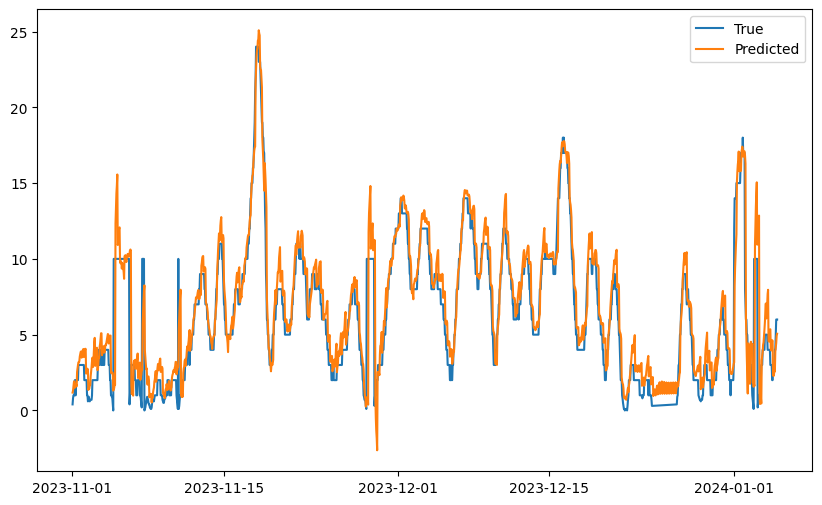

MSE: 3.218727267533678
R2: 0.8400051961296857
RMSE: 1.7940811764058164
MAPE: nan


In [75]:
metrics_and_plot(predictions_chor_pm10, test_chor_pm10['PM_10'])

In [76]:
#train for effect measure
series = ['PM_10','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 240
steps = 24

model_chor_pm10_effect, forecaster_chor_pm10_effect,data_chor_effect, train_chor_pm10_effect,val_chor_pm10_effect,test_chor_pm10_effect = build_model(chor_training, series, lags, steps, 4, 128,False)

In [ ]:
val_chor_pm10_effect

,PM_10,Humidity,Temperature,Windspeed,WindDirection,Precipitation
Date,,,,,,
2023-11-15 01:00:00,7.0,94.2,9.7,4.7,273.0,0.0
2023-11-15 02:00:00,6.0,93.9,10.1,5.1,268.0,0.1
2023-11-15 03:00:00,6.0,93.0,10.3,5.1,268.0,0.0
2023-11-15 04:00:00,5.0,91.1,10.6,5.4,266.0,0.0
2023-11-15 05:00:00,5.0,87.6,10.8,5.9,265.0,0.1
...,...,...,...,...,...,...
2024-01-08 20:00:00,5.0,52.2,-2.7,3.0,55.0,0.0
2024-01-08 21:00:00,5.0,53.9,-3.0,2.4,61.0,0.0
2024-01-08 22:00:00,5.0,56.7,-3.3,2.1,47.0,0.0


In [77]:
forecaster_chor_pm10_effect, preds_chor_pm10_effect = train_model(forecaster_chor_pm10_effect,train_chor_pm10_effect,24)

Epoch 1/4
127/127 [==============================] - 7s 30ms/step - loss: 0.0308 - val_loss: 0.0312
Epoch 2/4
127/127 [==============================] - 3s 25ms/step - loss: 0.0049 - val_loss: 0.0234
Epoch 3/4
127/127 [==============================] - 3s 26ms/step - loss: 0.0042 - val_loss: 0.0238
Epoch 4/4
127/127 [==============================] - 3s 24ms/step - loss: 0.0036 - val_loss: 0.0235


In [78]:
metrics_chor_pm10_effect, predictions_chor_pm10_effect = backtesting_evaluation(forecaster_chor_pm10_effect,data_chor_effect, '2024-01-09 00:00:00')

Epoch 1/4
137/137 [==============================] - 7s 32ms/step - loss: 0.0037 - val_loss: 0.0195
Epoch 2/4
137/137 [==============================] - 3s 23ms/step - loss: 0.0036 - val_loss: 0.0193
Epoch 3/4
137/137 [==============================] - 3s 23ms/step - loss: 0.0035 - val_loss: 0.0188
Epoch 4/4
137/137 [==============================] - 3s 25ms/step - loss: 0.0034 - val_loss: 0.0171


  0%|          | 0/66 [00:00<?, ?it/s]

In [ ]:
predictions_chor_pm10_effect

,PM_10
2024-01-09 01:00:00,5.733382
2024-01-09 02:00:00,6.110192
2024-01-09 03:00:00,6.288692
2024-01-09 04:00:00,6.549231
2024-01-09 05:00:00,6.630980
...,...
2024-03-14 20:00:00,6.395879
2024-03-14 21:00:00,6.376263
2024-03-14 22:00:00,6.221809
2024-03-14 23:00:00,6.423785


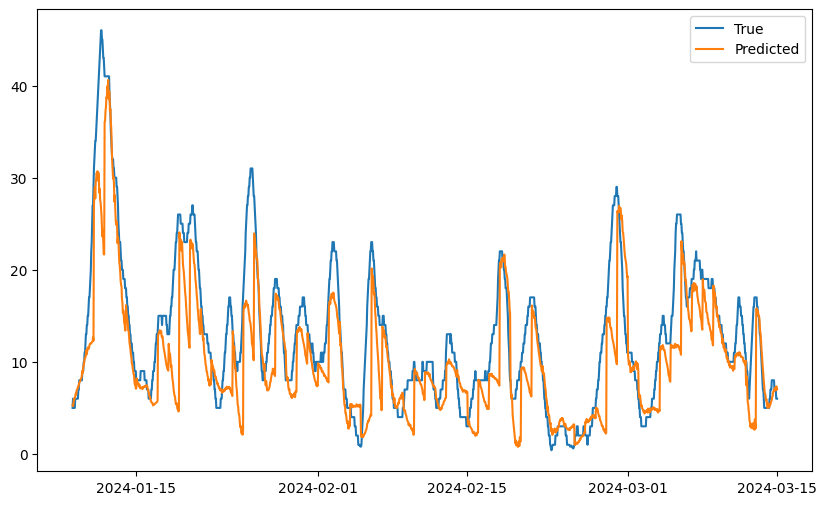

MSE: 28.634137902841815
R2: 0.5580113989094104
RMSE: 5.351087543933645
MAPE: nan


In [79]:
metrics_and_plot(predictions_chor_pm10_effect, test_chor_pm10_effect['PM_10'])

In [90]:
effect_measure(predictions_chor_pm10_effect, test_chor_pm10_effect,'PM_10')

Mean difference between strike prediction and real observation: -2.3611026067991516
Mean percent difference between strike prediction and real observation: 53.566233601231175
Mean difference between strike prediction and real observation GDL: -5.377980909683631
Mean percent difference between strike prediction and real observation GDL: 73.04260503735811


PM_10 Clevischer

In [81]:
series = ['PM_10','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 240
steps = 24
model_cle_pm10, forecaster_cle_pm10,data_cle, train_cle_pm10,val_cle_pm10,test_cle_pm10 = build_model(cle_training, series, lags, steps, 4, 128,True)

In [82]:
forecaster_cle_pm10, preds_cle_pm10 = train_model(forecaster_cle_pm10,train_cle_pm10,5)

Epoch 1/4
103/103 [==============================] - 5s 16ms/step - loss: 0.0088 - val_loss: 0.0011
Epoch 2/4
103/103 [==============================] - 1s 9ms/step - loss: 7.4467e-04 - val_loss: 0.0017
Epoch 3/4
103/103 [==============================] - 1s 12ms/step - loss: 6.2783e-04 - val_loss: 0.0014
Epoch 4/4
103/103 [==============================] - 1s 12ms/step - loss: 5.2520e-04 - val_loss: 5.2703e-04


In [83]:
metrics_cle_pm10, predictions_cle_pm10 = backtesting_evaluation(forecaster_cle_pm10,data_cle, '2023-11-01 00:00:00')

Epoch 1/4
126/126 [==============================] - 4s 15ms/step - loss: 3.9323e-04 - val_loss: 5.5284e-04
Epoch 2/4
126/126 [==============================] - 1s 9ms/step - loss: 3.5278e-04 - val_loss: 4.7155e-04
Epoch 3/4
126/126 [==============================] - 1s 9ms/step - loss: 3.6295e-04 - val_loss: 4.1339e-04
Epoch 4/4
126/126 [==============================] - 1s 9ms/step - loss: 3.5228e-04 - val_loss: 5.5610e-04


  0%|          | 0/312 [00:00<?, ?it/s]

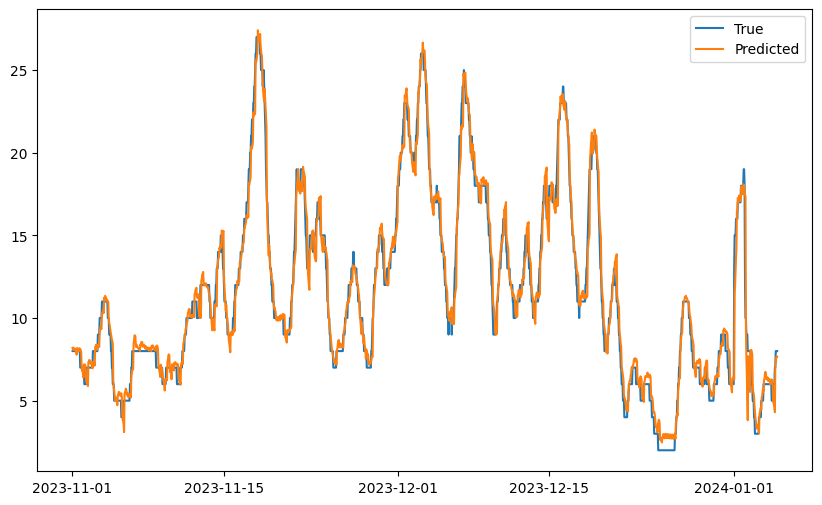

MSE: 0.8546362088073667
R2: 0.9724179541117854
RMSE: 0.9244653637683603
MAPE: nan


In [64]:
metrics_and_plot(predictions_cle_pm10, test_cle_pm10['PM_10'])

In [91]:
#effect measure
series = ['PM_10','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 240
steps = 24
model_cle_pm10_effect, forecaster_cle_pm10_effect,data_cle_effect, train_cle_pm10_effect,val_cle_pm10_effect,test_cle_pm10_effect = build_model(cle_training, series, lags, steps, 4, 128,False)

In [92]:
forecaster_cle_pm10_effect, preds_cle_pm10_effect = train_model(forecaster_cle_pm10_effect, train_cle_pm10_effect,24)

Epoch 1/4
127/127 [==============================] - 7s 31ms/step - loss: 0.0258 - val_loss: 0.0209
Epoch 2/4
127/127 [==============================] - 3s 25ms/step - loss: 0.0046 - val_loss: 0.0286
Epoch 3/4
127/127 [==============================] - 4s 28ms/step - loss: 0.0055 - val_loss: 0.0242
Epoch 4/4
127/127 [==============================] - 3s 24ms/step - loss: 0.0037 - val_loss: 0.0296


In [93]:
metrics_cle_pm10_effect, predictions_cle_pm10_effect = backtesting_evaluation(forecaster_cle_pm10_effect,data_cle_effect, '2024-01-09 00:00:00')

Epoch 1/4
137/137 [==============================] - 7s 30ms/step - loss: 0.0035 - val_loss: 0.0194
Epoch 2/4
137/137 [==============================] - 4s 26ms/step - loss: 0.0032 - val_loss: 0.0181
Epoch 3/4
137/137 [==============================] - 3s 25ms/step - loss: 0.0031 - val_loss: 0.0153
Epoch 4/4
137/137 [==============================] - 3s 24ms/step - loss: 0.0032 - val_loss: 0.0211


  0%|          | 0/66 [00:00<?, ?it/s]

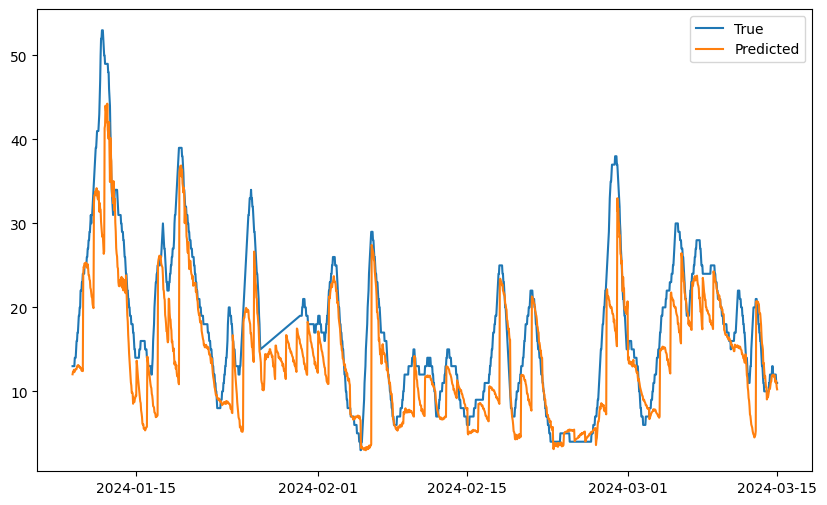

MSE: 36.75545724719543
R2: 0.550063657338149
RMSE: 6.062627915944985
MAPE: nan


In [94]:
metrics_and_plot(predictions_cle_pm10_effect, test_cle_pm10_effect['PM_10'])

In [96]:
effect_measure(predictions_cle_pm10_effect, test_cle_pm10_effect,'PM_10')

Mean difference between strike prediction and real observation: -2.4412016804153853
Mean percent difference between strike prediction and real observation: 20.85832854952322
Mean difference between strike prediction and real observation GDL: -5.946950599579966
Mean percent difference between strike prediction and real observation GDL: 47.15588356137504


PM_10 Turiner

In [97]:
series = ['PM_10','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 240
steps = 24
model_turi_pm10, forecaster_turi_pm10,data_turi, train_turi_pm10,val_turi_pm10,test_turi_pm10 = build_model(turi_training, series, lags, steps, 4, 128,True)

In [98]:
forecaster_turi_pm10, preds_turi_pm10 = train_model(forecaster_turi_pm10,train_turi_pm10,5)

Epoch 1/4
103/103 [==============================] - 5s 16ms/step - loss: 0.0173 - val_loss: 0.0037
Epoch 2/4
103/103 [==============================] - 1s 11ms/step - loss: 9.1659e-04 - val_loss: 0.0011
Epoch 3/4
103/103 [==============================] - 1s 13ms/step - loss: 5.3373e-04 - val_loss: 0.0010
Epoch 4/4
103/103 [==============================] - 1s 12ms/step - loss: 5.3116e-04 - val_loss: 5.0422e-04


In [99]:
metrics_turi_pm10, predictions_turi_pm10 = backtesting_evaluation(forecaster_turi_pm10,data_turi, '2023-11-01 00:00:00')

Epoch 1/4
126/126 [==============================] - 4s 15ms/step - loss: 4.0486e-04 - val_loss: 6.4476e-04
Epoch 2/4
126/126 [==============================] - 1s 9ms/step - loss: 4.2471e-04 - val_loss: 7.3397e-04
Epoch 3/4
126/126 [==============================] - 1s 9ms/step - loss: 3.8685e-04 - val_loss: 4.2778e-04
Epoch 4/4
126/126 [==============================] - 1s 10ms/step - loss: 4.4249e-04 - val_loss: 4.8435e-04


  0%|          | 0/312 [00:00<?, ?it/s]

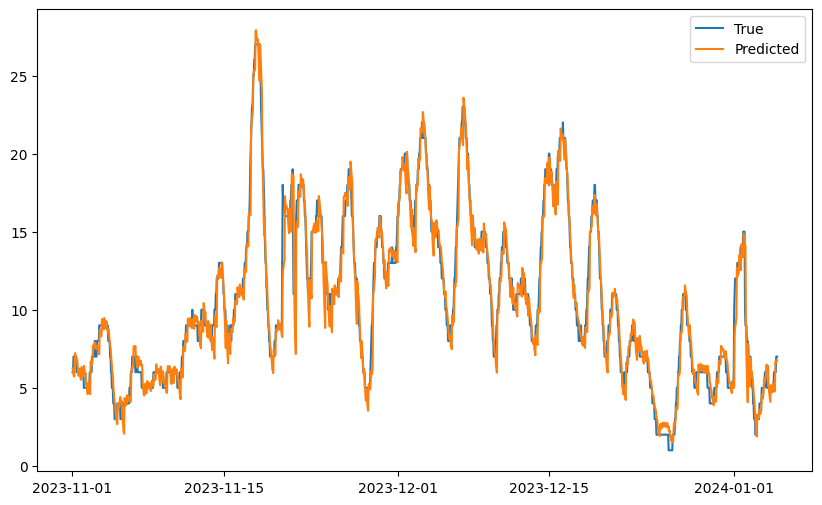

MSE: 1.0748048797931815
R2: 0.9605715026234786
RMSE: 1.036727968077056
MAPE: nan


In [100]:
metrics_and_plot(predictions_turi_pm10, test_turi_pm10['PM_10'])

In [101]:
#effect measure
series = ['PM_10','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 240
steps = 24
model_turi_pm10_effect, forecaster_turi_pm10_effect,data_turi_effect, train_turi_pm10_effect,val_turi_pm10_effect,test_turi_pm10_effect = build_model(turi_training, series, lags, steps, 4, 128,False)

In [ ]:
forecaster_turi_pm10_effect, preds_turi_pm10_effect = train_model(forecaster_turi_pm10_effect, train_turi_pm10_effect,24)

Epoch 1/4
127/127 [==============================] - 8s 32ms/step - loss: 0.0242 - val_loss: 0.0209
Epoch 2/4
127/127 [==============================] - 3s 23ms/step - loss: 0.0050 - val_loss: 0.0308
Epoch 3/4
127/127 [==============================] - 3s 23ms/step - loss: 0.0043 - val_loss: 0.0322
Epoch 4/4
127/127 [==============================] - 3s 27ms/step - loss: 0.0043 - val_loss: 0.0227


In [102]:
metrics_turi_pm10_effect, predictions_turi_pm10_effect = backtesting_evaluation(forecaster_turi_pm10_effect,data_turi_effect, '2024-01-09 00:00:00')

Epoch 1/4
137/137 [==============================] - 8s 31ms/step - loss: 0.0373 - val_loss: 0.0213
Epoch 2/4
137/137 [==============================] - 3s 24ms/step - loss: 0.0043 - val_loss: 0.0155
Epoch 3/4
137/137 [==============================] - 3s 24ms/step - loss: 0.0036 - val_loss: 0.0164
Epoch 4/4
137/137 [==============================] - 4s 27ms/step - loss: 0.0033 - val_loss: 0.0156


  0%|          | 0/66 [00:00<?, ?it/s]

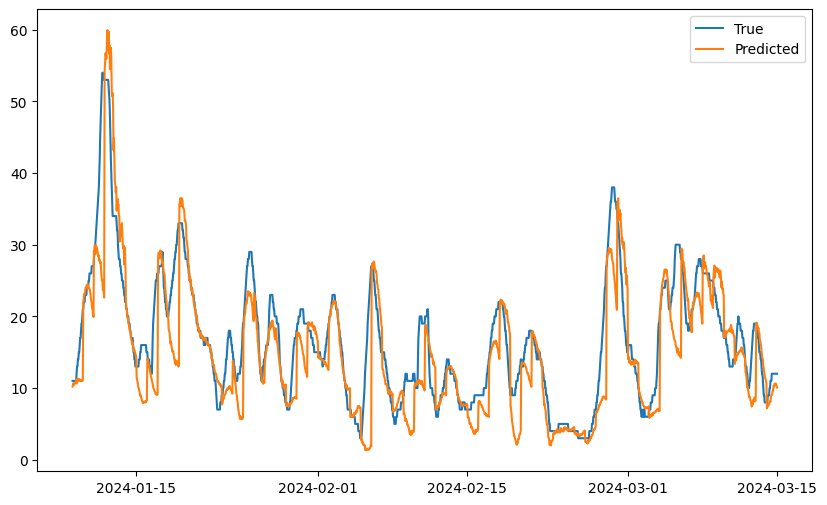

MSE: 30.4693010602884
R2: 0.614343275085885
RMSE: 5.519900457461928
MAPE: nan


In [103]:
metrics_and_plot(predictions_turi_pm10_effect, test_turi_pm10_effect['PM_10'])

In [104]:
effect_measure(predictions_turi_pm10_effect, test_turi_pm10_effect,'PM_10')

Mean difference between strike prediction and real observation: -1.0051802300118111
Mean percent difference between strike prediction and real observation: 33.270386715953336
Mean difference between strike prediction and real observation GDL: -3.122973729860415
Mean percent difference between strike prediction and real observation GDL: 30.337396594989197


In [105]:
series = ['PM_10','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 240
steps = 24
model_rod_pm10, forecaster_rod_pm10,data_rod, train_rod_pm10,val_rod_pm10,test_rod_pm10 = build_model(rod_training, series, lags, steps, 4, 128,True)

In [106]:
forecaster_rod_pm10, preds_rod_pm10 = train_model(forecaster_rod_pm10,train_rod_pm10,5)

Epoch 1/4
103/103 [==============================] - 6s 17ms/step - loss: 0.0161 - val_loss: 0.0026
Epoch 2/4
103/103 [==============================] - 1s 9ms/step - loss: 7.9675e-04 - val_loss: 0.0046
Epoch 3/4
103/103 [==============================] - 1s 9ms/step - loss: 6.4000e-04 - val_loss: 9.2007e-04
Epoch 4/4
103/103 [==============================] - 1s 9ms/step - loss: 5.1338e-04 - val_loss: 0.0012


In [107]:
metrics_rod_pm10, predictions_rod_pm10 = backtesting_evaluation(forecaster_rod_pm10,data_rod, '2023-11-01 00:00:00')

Epoch 1/4
126/126 [==============================] - 5s 17ms/step - loss: 4.1785e-04 - val_loss: 7.5920e-04
Epoch 2/4
126/126 [==============================] - 2s 13ms/step - loss: 3.9617e-04 - val_loss: 9.7416e-04
Epoch 3/4
126/126 [==============================] - 1s 11ms/step - loss: 3.9807e-04 - val_loss: 6.5205e-04
Epoch 4/4
126/126 [==============================] - 2s 17ms/step - loss: 3.6102e-04 - val_loss: 0.0015


  0%|          | 0/312 [00:00<?, ?it/s]

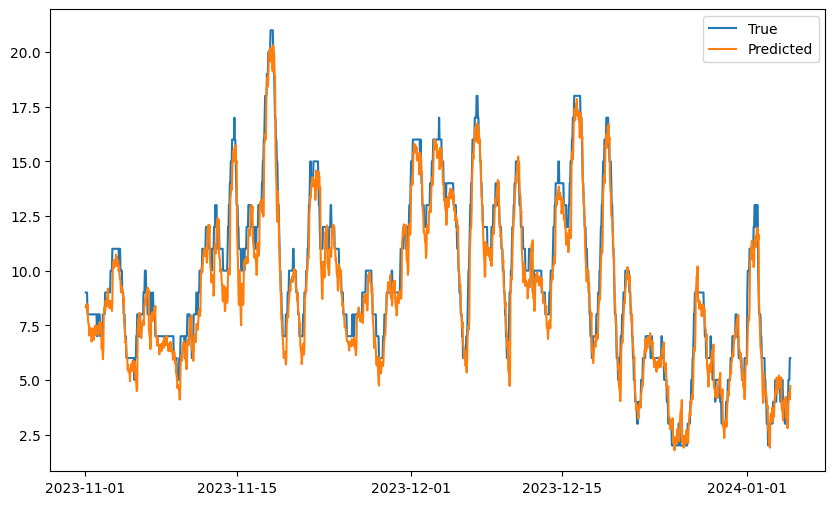

MSE: 0.9833806304920066
R2: 0.9320932610273596
RMSE: 0.9916554999050863
MAPE: nan


In [108]:
metrics_and_plot(predictions_rod_pm10, test_rod_pm10['PM_10'])

In [109]:
#effect measure
series = ['PM_10','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 240
steps = 24


model_rod_pm10_effect, forecaster_rod_pm10_effect,data_rod_effect, train_rod_pm10_effect,val_rod_pm10_effect,test_rod_pm10_effect = build_model(rod_training, series, lags, steps, 4, 128,False)


In [110]:
forecaster_rod_pm10_effect, preds_rod_pm10_effect = train_model(forecaster_rod_pm10_effect,train_rod_pm10_effect,24)

Epoch 1/4
127/127 [==============================] - 12s 30ms/step - loss: 0.0408 - val_loss: 0.0227
Epoch 2/4
127/127 [==============================] - 3s 24ms/step - loss: 0.0046 - val_loss: 0.0453
Epoch 3/4
127/127 [==============================] - 3s 27ms/step - loss: 0.0043 - val_loss: 0.0180
Epoch 4/4
127/127 [==============================] - 3s 25ms/step - loss: 0.0039 - val_loss: 0.0634


In [111]:
metrics_rod_pm10_effect, predictions_rod_pm10_effect = backtesting_evaluation(forecaster_rod_pm10_effect,data_rod_effect, '2024-01-09 00:00:00')

Epoch 1/4
137/137 [==============================] - 7s 29ms/step - loss: 0.0046 - val_loss: 0.0208
Epoch 2/4
137/137 [==============================] - 3s 24ms/step - loss: 0.0030 - val_loss: 0.0189
Epoch 3/4
137/137 [==============================] - 4s 26ms/step - loss: 0.0029 - val_loss: 0.0214
Epoch 4/4
137/137 [==============================] - 3s 23ms/step - loss: 0.0028 - val_loss: 0.0176


  0%|          | 0/66 [00:00<?, ?it/s]

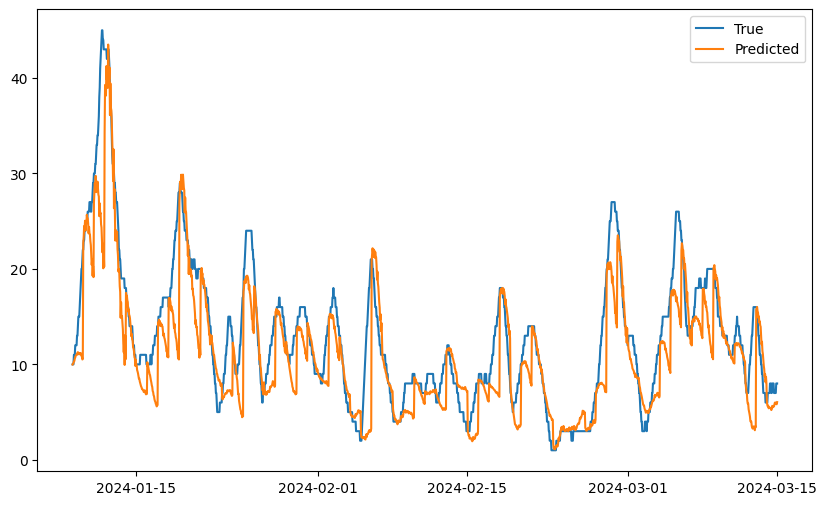

MSE: 18.08407641100171
R2: 0.6847313275202991
RMSE: 4.252537643690142
MAPE: nan


In [112]:
metrics_and_plot(predictions_rod_pm10_effect, test_rod_pm10_effect['PM_10'])

In [113]:
effect_measure(predictions_rod_pm10_effect, test_rod_pm10_effect,'PM_10')

Mean difference between strike prediction and real observation: -1.909007046673749
Mean percent difference between strike prediction and real observation: 35.98421320005373
Mean difference between strike prediction and real observation GDL: -3.934602607189296
Mean percent difference between strike prediction and real observation GDL: 47.64272750569111


No2

In [114]:
series = ['NO2','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 240
steps = 24

model_chor_no2, forecaster_chor_no2,data_chor, train_chor_no2,val_chor_no2,test_chor_no2 = build_model(chor_training, series, lags, steps, 4, 128,True)


In [115]:
forecaster_chor_no2, preds_chor_no2 = train_model(forecaster_chor_no2,train_chor_no2,5)

Epoch 1/4
103/103 [==============================] - 5s 16ms/step - loss: 0.0268 - val_loss: 0.0145
Epoch 2/4
103/103 [==============================] - 1s 10ms/step - loss: 0.0103 - val_loss: 0.0129
Epoch 3/4
103/103 [==============================] - 1s 12ms/step - loss: 0.0096 - val_loss: 0.0126
Epoch 4/4
103/103 [==============================] - 1s 12ms/step - loss: 0.0091 - val_loss: 0.0126


In [116]:
metrics_chor_no2, predictions_chor_no2 = backtesting_evaluation(forecaster_chor_no2,data_chor, '2023-11-01 00:00:00')

Epoch 1/4
126/126 [==============================] - 4s 16ms/step - loss: 0.0082 - val_loss: 0.0113
Epoch 2/4
126/126 [==============================] - 2s 12ms/step - loss: 0.0080 - val_loss: 0.0103
Epoch 3/4
126/126 [==============================] - 1s 12ms/step - loss: 0.0079 - val_loss: 0.0110
Epoch 4/4
126/126 [==============================] - 1s 9ms/step - loss: 0.0076 - val_loss: 0.0112


  0%|          | 0/312 [00:00<?, ?it/s]

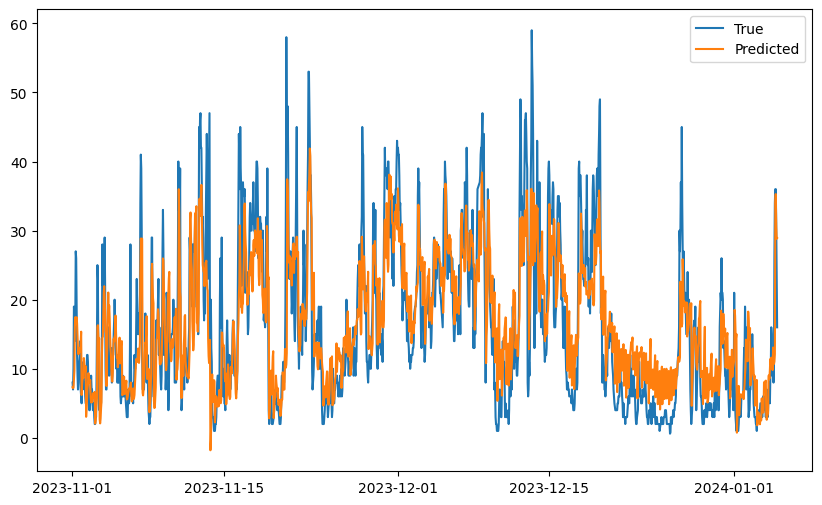

MSE: 52.16442191455532
R2: 0.6180190539173209
RMSE: 7.222494161614485
MAPE: nan


In [117]:
metrics_and_plot(predictions_chor_no2, test_chor_no2['NO2'])

Epoch 1/4
127/127 [==============================] - 9s 40ms/step - loss: 0.0367 - val_loss: 0.0323
Epoch 2/4
127/127 [==============================] - 3s 25ms/step - loss: 0.0155 - val_loss: 0.0512
Epoch 3/4
127/127 [==============================] - 3s 28ms/step - loss: 0.0155 - val_loss: 0.0323
Epoch 4/4
127/127 [==============================] - 3s 27ms/step - loss: 0.0141 - val_loss: 0.0326
Epoch 1/4
137/137 [==============================] - 6s 29ms/step - loss: 0.0140 - val_loss: 0.0315
Epoch 2/4
137/137 [==============================] - 3s 23ms/step - loss: 0.0135 - val_loss: 0.0299
Epoch 3/4
137/137 [==============================] - 4s 26ms/step - loss: 0.0134 - val_loss: 0.0288
Epoch 4/4
137/137 [==============================] - 3s 23ms/step - loss: 0.0131 - val_loss: 0.0289


  0%|          | 0/66 [00:00<?, ?it/s]

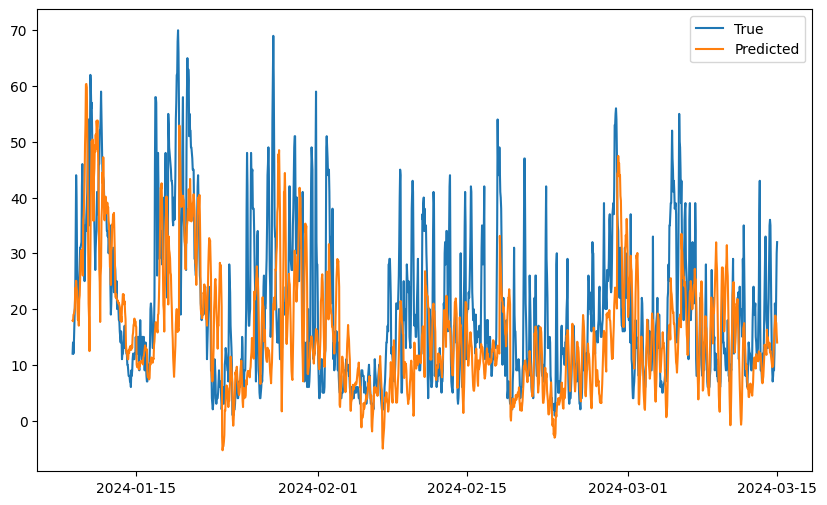

MSE: 166.8231997580894
R2: 0.09987338714804439
RMSE: 12.9160055651153
MAPE: nan
Mean difference between strike prediction and real observation: -2.9397176375260226
Mean percent difference between strike prediction and real observation: 67.32757344329092
Mean difference between strike prediction and real observation GDL: -4.495824456214905
Mean percent difference between strike prediction and real observation GDL: 85.49521944303532


In [118]:

series = ['NO2','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 240
steps = 24

model_chor_no2_effect,forecaster_chor_no2_effect,data_chor_effect, train_chor_no2_effect,val_chor_no2_effect,test_chor_no2_effect = build_model(chor_training, series, lags, steps, 4, 128,False)
forecaster_chor_no2_effect, preds_chor_no2_effect = train_model(forecaster_chor_no2_effect,train_chor_no2_effect,5)
metrics_chor_no2_effect, predictions_chor_no2_effect = backtesting_evaluation(forecaster_chor_no2_effect,data_chor_effect, '2024-01-09 00:00:00')

metrics_and_plot(predictions_chor_no2_effect, test_chor_no2_effect['NO2'])
effect_measure(predictions_chor_no2_effect, test_chor_no2_effect,'NO2')

In [161]:
series = ['NO2','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 100
steps = 5
model_cle_no2, forecaster_cle_no2,data_cle, train_cle_no2,val_cle_no2,test_cle_no2 = build_model(cle_training, series, lags, steps, 4, 128,True)

In [162]:
forecaster_cle_no2, preds_cle_no2 = train_model(forecaster_cle_no2,train_cle_no2,5)

Epoch 1/4
102/102 [==============================] - 7s 28ms/step - loss: 0.0306 - val_loss: 0.0131
Epoch 2/4
102/102 [==============================] - 1s 13ms/step - loss: 0.0112 - val_loss: 0.0104
Epoch 3/4
102/102 [==============================] - 1s 13ms/step - loss: 0.0099 - val_loss: 0.0095
Epoch 4/4
102/102 [==============================] - 1s 13ms/step - loss: 0.0094 - val_loss: 0.0087


In [163]:
metrics_cle_no2, predictions_cle_no2 = backtesting_evaluation(forecaster_cle_no2,data_cle, '2023-11-01 00:00:00')

Epoch 1/4
125/125 [==============================] - 6s 20ms/step - loss: 0.0089 - val_loss: 0.0091
Epoch 2/4
125/125 [==============================] - 2s 12ms/step - loss: 0.0084 - val_loss: 0.0082
Epoch 3/4
125/125 [==============================] - 2s 13ms/step - loss: 0.0083 - val_loss: 0.0081
Epoch 4/4
125/125 [==============================] - 2s 12ms/step - loss: 0.0079 - val_loss: 0.0081


  0%|          | 0/312 [00:00<?, ?it/s]

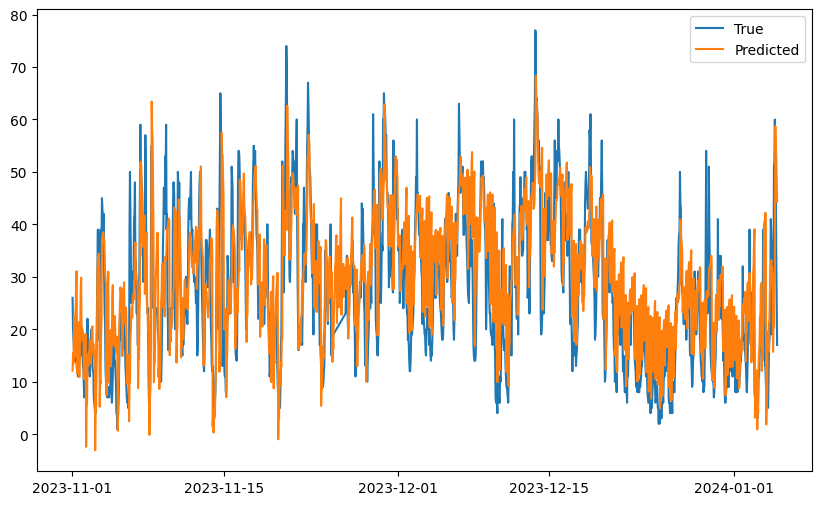

MSE: 117.32598982872699
R2: 0.40426418972236233
RMSE: 10.831712229778217
MAPE: nan


In [164]:
metrics_and_plot(predictions_cle_no2, test_cle_no2['NO2'])

Epoch 1/4
128/128 [==============================] - 5s 15ms/step - loss: 0.0176 - val_loss: 0.0250
Epoch 2/4
128/128 [==============================] - 1s 9ms/step - loss: 0.0096 - val_loss: 0.0179
Epoch 3/4
128/128 [==============================] - 1s 8ms/step - loss: 0.0088 - val_loss: 0.0195
Epoch 4/4
128/128 [==============================] - 1s 11ms/step - loss: 0.0084 - val_loss: 0.0171
Epoch 1/4
138/138 [==============================] - 4s 14ms/step - loss: 0.0076 - val_loss: 0.0166
Epoch 2/4
138/138 [==============================] - 1s 10ms/step - loss: 0.0073 - val_loss: 0.0186
Epoch 3/4
138/138 [==============================] - 2s 12ms/step - loss: 0.0072 - val_loss: 0.0152
Epoch 4/4
138/138 [==============================] - 1s 10ms/step - loss: 0.0069 - val_loss: 0.0164


  0%|          | 0/317 [00:00<?, ?it/s]

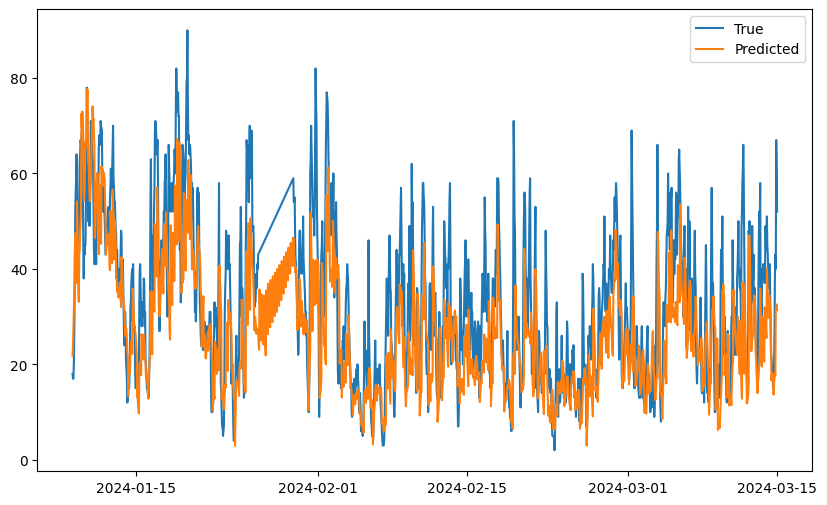

Mean difference between strike prediction and real observation: -5.565769595068854
Mean percent difference between strike prediction and real observation: 28.611635535230924
Mean difference between strike prediction and real observation GDL: -8.593653485638455
Mean percent difference between strike prediction and real observation GDL: 31.174001249156078


{'mean_diff': -5.565769595068854,
 'mean_percent_diff': 28.611635535230924,
 'mean_diff_GDL': -8.593653485638455,
 'mean_percent_diff_GDL': 31.174001249156078}

In [ ]:
series = ['NO2','Humidity','Temperature','Windspeed','WindDirection','Precipitation']
lags = 240
steps= 24
model_cle_no2_effect,forecaster_cle_no2_effect,data_cle_effect, train_cle_no2_effect,val_cle_no2_effect,test_cle_no2_effect = build_model(cle_training, series, lags, steps, 4, 128,False)
forecaster_cle_no2_effect, preds_cle_no2_effect = train_model(forecaster_cle_no2_effect,train_cle_no2_effect,5)
metrics_cle_no2_effect, predictions_cle_no2_effect = backtesting_evaluation(forecaster_cle_no2_effect,data_cle_effect, '2024-01-09 00:00:00')
metrics_and_plot(predictions_cle_no2_effect, test_cle_no2_effect['NO2'])
effect_measure(predictions_cle_no2_effect, test_cle_no2_effect,'NO2')

In [ ]:
series = ['NO2','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 240
steps = 24
model_turi_no2, forecaster_turi_no2,data_turi, train_turi_no2,val_turi_no2,test_turi_no2 = build_model(turi_training, series, lags, steps, 4, 128,True)

In [ ]:
forecaster_turi_no2, preds_turi_no2 = train_model(forecaster_turi_no2,train_turi_no2,5)

Epoch 1/4
102/102 [==============================] - 7s 17ms/step - loss: 0.0123 - val_loss: 0.0074
Epoch 2/4
102/102 [==============================] - 1s 9ms/step - loss: 0.0057 - val_loss: 0.0060
Epoch 3/4
102/102 [==============================] - 1s 9ms/step - loss: 0.0051 - val_loss: 0.0060
Epoch 4/4
102/102 [==============================] - 1s 9ms/step - loss: 0.0047 - val_loss: 0.0056


In [ ]:
metrics_turi_no2, predictions_turi_no2 = backtesting_evaluation(forecaster_turi_no2,data_turi, '2023-11-01 00:00:00')

Epoch 1/4
126/126 [==============================] - 6s 21ms/step - loss: 0.0046 - val_loss: 0.0062
Epoch 2/4
126/126 [==============================] - 1s 11ms/step - loss: 0.0044 - val_loss: 0.0059
Epoch 3/4
126/126 [==============================] - 2s 16ms/step - loss: 0.0043 - val_loss: 0.0052
Epoch 4/4
126/126 [==============================] - 2s 14ms/step - loss: 0.0042 - val_loss: 0.0050


  0%|          | 0/312 [00:00<?, ?it/s]

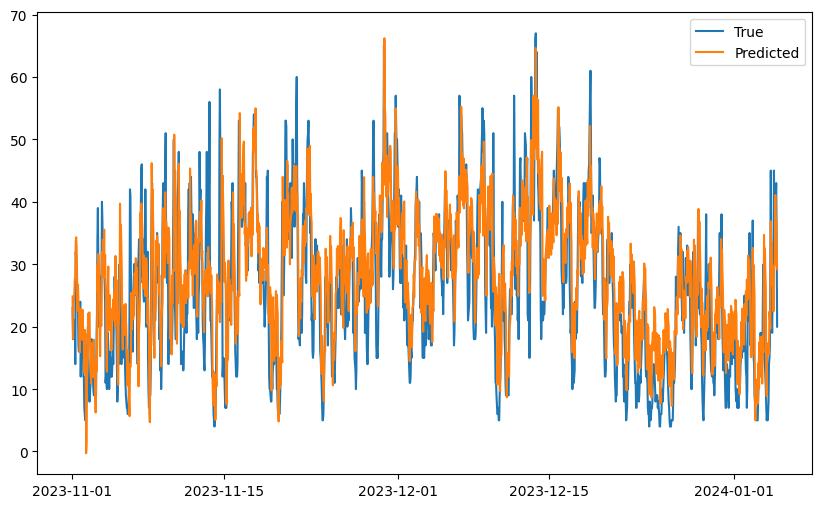

(71.68213136505081, 0.5386558573762867)

In [ ]:
metrics_and_plot(predictions_turi_no2, test_turi_no2['NO2'])

Epoch 1/4
128/128 [==============================] - 8s 20ms/step - loss: 0.0176 - val_loss: 0.0318
Epoch 2/4
128/128 [==============================] - 1s 9ms/step - loss: 0.0058 - val_loss: 0.0216
Epoch 3/4
128/128 [==============================] - 1s 9ms/step - loss: 0.0050 - val_loss: 0.0218
Epoch 4/4
128/128 [==============================] - 1s 10ms/step - loss: 0.0047 - val_loss: 0.0203
Epoch 1/4
138/138 [==============================] - 4s 14ms/step - loss: 0.0044 - val_loss: 0.0269
Epoch 2/4
138/138 [==============================] - 1s 8ms/step - loss: 0.0043 - val_loss: 0.0182
Epoch 3/4
138/138 [==============================] - 1s 9ms/step - loss: 0.0042 - val_loss: 0.0215
Epoch 4/4
138/138 [==============================] - 1s 9ms/step - loss: 0.0040 - val_loss: 0.0201


  0%|          | 0/317 [00:00<?, ?it/s]

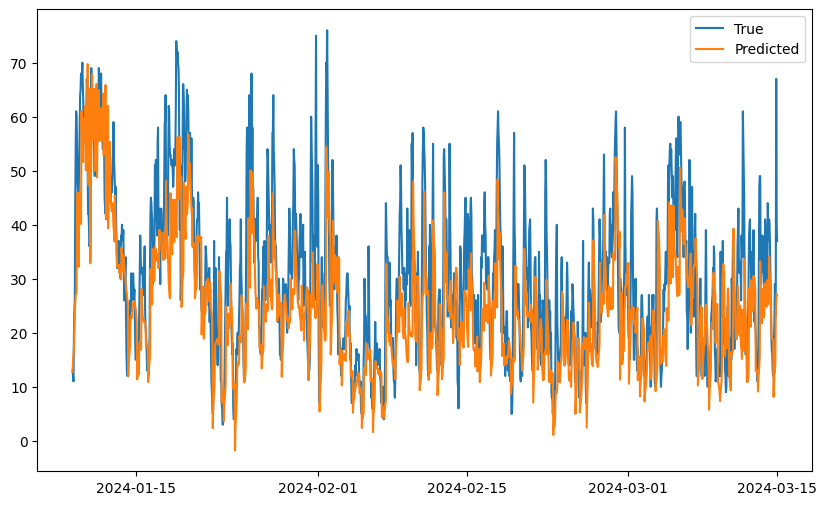

Mean difference between strike prediction and real observation: -4.510350394893337
Mean percent difference between strike prediction and real observation: 29.19803960262927
Mean difference between strike prediction and real observation GDL: -4.648946918579975
Mean percent difference between strike prediction and real observation GDL: 29.447476664049677


{'mean_diff': -4.510350394893337,
 'mean_percent_diff': 29.19803960262927,
 'mean_diff_GDL': -4.648946918579975,
 'mean_percent_diff_GDL': 29.447476664049677}

In [ ]:
series = ['NO2','Humidity','Temperature','Windspeed','WindDirection','Precipitation']
lags= 300
steps = 24
model_turi_no2_effect,forecaster_turi_no2_effect,data_turi_effect, train_turi_no2_effect,val_turi_no2_effect,test_turi_no2_effect = build_model(turi_training, series, lags, steps, 4, 128,False)
forecaster_turi_no2_effect, preds_turi_no2_effect = train_model(forecaster_turi_no2_effect,train_turi_no2_effect,5)
metrics_turi_no2_effect, predictions_turi_no2_effect = backtesting_evaluation(forecaster_turi_no2_effect,data_turi_effect, '2024-01-09 00:00:00')
metrics_and_plot(predictions_turi_no2_effect, test_turi_no2_effect['NO2'])
effect_measure(predictions_turi_no2_effect, test_turi_no2_effect,'NO2')

In [ ]:
series = ['NO2','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 300
steps = 24
model_rod_no2, forecaster_rod_no2,data_rod, train_rod_no2,val_rod_no2,test_rod_no2 = build_model(rod_training, series, lags, steps, 4, 128,True)

In [ ]:
forecaster_rod_no2, preds_rod_no2 = train_model(forecaster_rod_no2,train_rod_no2,5)

Epoch 1/4
102/102 [==============================] - 5s 17ms/step - loss: 0.0143 - val_loss: 0.0084
Epoch 2/4
102/102 [==============================] - 1s 9ms/step - loss: 0.0054 - val_loss: 0.0073
Epoch 3/4
102/102 [==============================] - 1s 13ms/step - loss: 0.0050 - val_loss: 0.0076
Epoch 4/4
102/102 [==============================] - 1s 13ms/step - loss: 0.0046 - val_loss: 0.0068


In [ ]:
metrics_rod_no2, predictions_rod_no2 = backtesting_evaluation(forecaster_rod_no2,data_rod, '2023-11-01 00:00:00')

Epoch 1/4
126/126 [==============================] - 7s 26ms/step - loss: 0.0043 - val_loss: 0.0075
Epoch 2/4
126/126 [==============================] - 1s 9ms/step - loss: 0.0043 - val_loss: 0.0076
Epoch 3/4
126/126 [==============================] - 1s 10ms/step - loss: 0.0044 - val_loss: 0.0078
Epoch 4/4
126/126 [==============================] - 1s 9ms/step - loss: 0.0043 - val_loss: 0.0062


  0%|          | 0/312 [00:00<?, ?it/s]

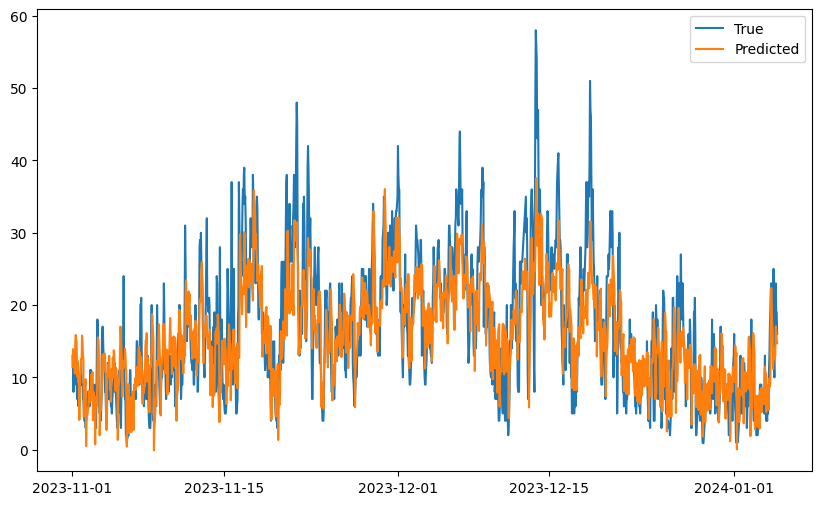

(38.41609559689418, 0.5738259841647564)

In [ ]:
metrics_and_plot(predictions_rod_no2, test_rod_no2['NO2'])

Epoch 1/4
128/128 [==============================] - 6s 20ms/step - loss: 0.0119 - val_loss: 0.0257
Epoch 2/4
128/128 [==============================] - 1s 10ms/step - loss: 0.0046 - val_loss: 0.0170
Epoch 3/4
128/128 [==============================] - 1s 9ms/step - loss: 0.0043 - val_loss: 0.0165
Epoch 4/4
128/128 [==============================] - 1s 9ms/step - loss: 0.0040 - val_loss: 0.0172
Epoch 1/4
138/138 [==============================] - 4s 14ms/step - loss: 0.0036 - val_loss: 0.0171
Epoch 2/4
138/138 [==============================] - 1s 10ms/step - loss: 0.0037 - val_loss: 0.0157
Epoch 3/4
138/138 [==============================] - 2s 12ms/step - loss: 0.0035 - val_loss: 0.0134
Epoch 4/4
138/138 [==============================] - 1s 10ms/step - loss: 0.0034 - val_loss: 0.0163


  0%|          | 0/317 [00:00<?, ?it/s]

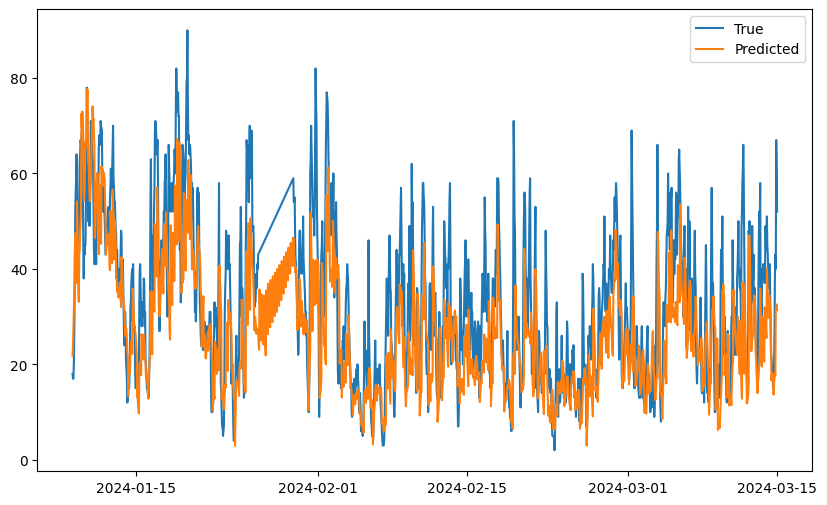

Mean difference between strike prediction and real observation: -5.121674621427381
Mean percent difference between strike prediction and real observation: 35.054017964030244
Mean difference between strike prediction and real observation GDL: -7.288191712375254
Mean percent difference between strike prediction and real observation GDL: 38.47730713175622


{'mean_diff': -5.121674621427381,
 'mean_percent_diff': 35.054017964030244,
 'mean_diff_GDL': -7.288191712375254,
 'mean_percent_diff_GDL': 38.47730713175622}

In [ ]:
series = ['NO2','Humidity','Temperature','Windspeed','WindDirection','Precipitation']
lags = 300
steps = 24

model_rod_no2_effect,forecaster_rod_no2_effect,data_rod_effect, train_rod_no2_effect,val_rod_no2_effect,test_rod_no2_effect = build_model(rod_training, series, lags, steps, 4, 128,False)
forecaster_rod_no2_effect, preds_rod_no2_effect = train_model(forecaster_rod_no2_effect,train_rod_no2_effect,24)
metrics_rod_no2_effect, predictions_rod_no2_effect = backtesting_evaluation(forecaster_rod_no2_effect,data_rod_effect, '2024-01-09 00:00:00')
metrics_and_plot(predictions_cle_no2_effect, test_cle_no2_effect['NO2'])
effect_measure(predictions_rod_no2_effect, test_rod_no2_effect,'NO2')

### O3

In [135]:
chor_training.dropna(inplace=True)

In [142]:
series =[ 'O3','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 240
steps = 24

model_chor_o3, forecaster_chor_o3,data_chor, train_chor_o3,val_chor_o3,test_chor_o3 = build_model(chor_training, series, lags, steps, 4, 128,True)


In [144]:
forecaster_chor_o3, preds_chor_o3 = train_model(forecaster_chor_o3,train_chor_o3,24)

Epoch 1/4
103/103 [==============================] - 1s 11ms/step - loss: 0.0045 - val_loss: 0.0073
Epoch 2/4
103/103 [==============================] - 1s 9ms/step - loss: 0.0043 - val_loss: 0.0074
Epoch 3/4
103/103 [==============================] - 1s 11ms/step - loss: 0.0043 - val_loss: 0.0076
Epoch 4/4
103/103 [==============================] - 1s 12ms/step - loss: 0.0040 - val_loss: 0.0071


In [145]:
metrics_chor_o3, predictions_chor_o3 = backtesting_evaluation(forecaster_chor_o3,data_chor, '2023-11-01 00:00:00')

Epoch 1/4
126/126 [==============================] - 4s 15ms/step - loss: 0.0040 - val_loss: 0.0062
Epoch 2/4
126/126 [==============================] - 1s 9ms/step - loss: 0.0039 - val_loss: 0.0064
Epoch 3/4
126/126 [==============================] - 1s 8ms/step - loss: 0.0039 - val_loss: 0.0060
Epoch 4/4
126/126 [==============================] - 1s 8ms/step - loss: 0.0039 - val_loss: 0.0060


  0%|          | 0/312 [00:00<?, ?it/s]

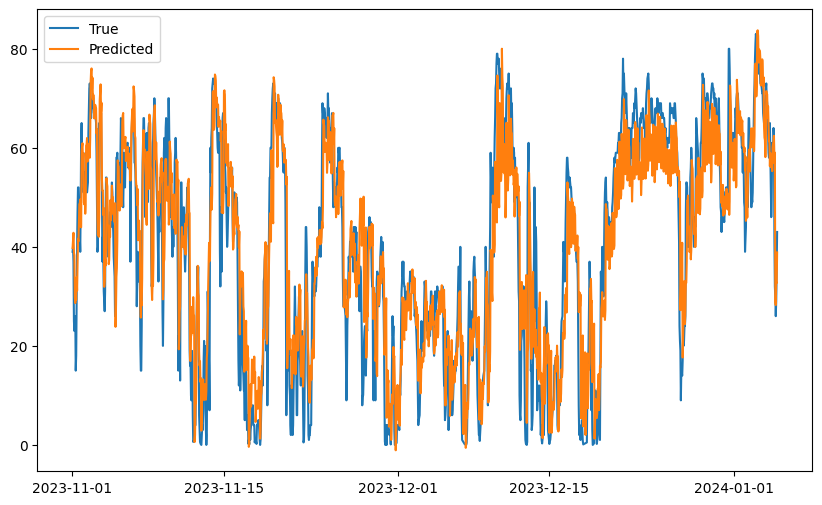

MSE: 114.83209714302886
R2: 0.7827323193580219
RMSE: 10.715973924148418
MAPE: nan


In [146]:
metrics_and_plot(predictions_chor_o3, test_chor_o3['O3'])

In [147]:
series = ['O3','Humidity','Temperature','Windspeed','WindDirection','Precipitation']
lags = 240
steps = 24
model_chor_o3_effect, forecaster_chor_o3_effect,data_chor_effect, train_chor_o3_effect,val_chor_o3_effect,test_chor_o3_effect = build_model(chor_training, series, lags, steps, 4, 128,False)

In [148]:
forecast_chor_o3_effect, preds_chor_o3_effect = train_model(forecaster_chor_o3_effect,train_chor_o3_effect,24)

Epoch 1/4
126/126 [==============================] - 9s 49ms/step - loss: 0.0373 - val_loss: 0.0537
Epoch 2/4
126/126 [==============================] - 3s 23ms/step - loss: 0.0109 - val_loss: 0.0578
Epoch 3/4
126/126 [==============================] - 3s 23ms/step - loss: 0.0102 - val_loss: 0.0583
Epoch 4/4
126/126 [==============================] - 3s 24ms/step - loss: 0.0096 - val_loss: 0.0695


In [149]:
metrics_chor_o3_effect, predictions_chor_o3_effect = backtesting_evaluation(forecaster_chor_o3_effect,data_chor_effect, '2024-01-09 00:00:00')

Epoch 1/4
137/137 [==============================] - 7s 33ms/step - loss: 0.0093 - val_loss: 0.0567
Epoch 2/4
137/137 [==============================] - 3s 23ms/step - loss: 0.0088 - val_loss: 0.0564
Epoch 3/4
137/137 [==============================] - 3s 23ms/step - loss: 0.0089 - val_loss: 0.0678
Epoch 4/4
137/137 [==============================] - 3s 24ms/step - loss: 0.0087 - val_loss: 0.0635


  0%|          | 0/66 [00:00<?, ?it/s]

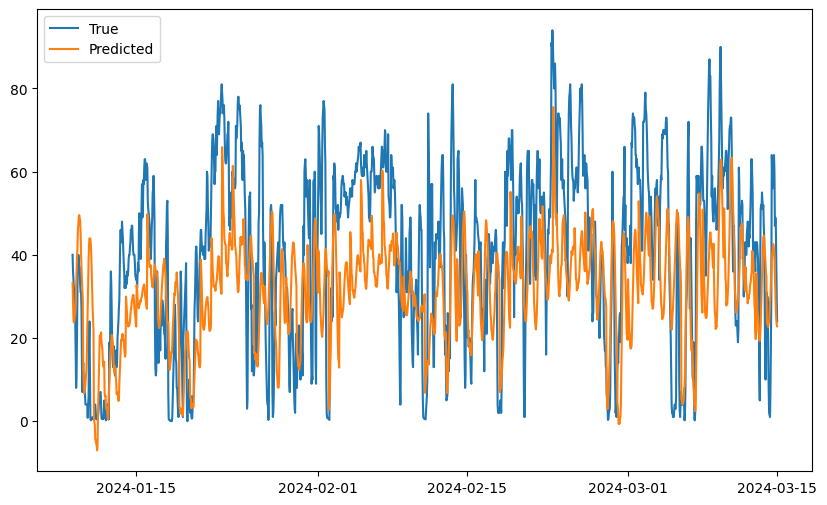

MSE: 405.65875532329517
R2: 0.13119225565723802
RMSE: 20.14097205507458
MAPE: nan


In [150]:
metrics_and_plot(predictions_chor_o3_effect, test_chor_o3_effect['O3'])

In [152]:
effect_measure(predictions_chor_o3_effect, test_chor_o3_effect,'O3')

Mean difference between strike prediction and real observation: -6.853594200816509
Mean percent difference between strike prediction and real observation: -22.004585534532193
Mean difference between strike prediction and real observation GDL: -2.9980066658116646
Mean percent difference between strike prediction and real observation GDL: 55.64254315939441


In [153]:
series =[ 'O3','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 240
steps = 24

model_rod_o3, forecaster_rod_o3,data_rod, train_rod_o3,val_rod_o3,test_rod_o3 = build_model(rod_training, series, lags, steps, 4, 128,True)

In [154]:
forecaster_rod_o3, preds_rod_o3 = train_model(forecaster_rod_o3,train_rod_o3,5)

Epoch 1/4
103/103 [==============================] - 6s 18ms/step - loss: 0.0192 - val_loss: 0.0093
Epoch 2/4
103/103 [==============================] - 1s 9ms/step - loss: 0.0064 - val_loss: 0.0096
Epoch 3/4
103/103 [==============================] - 1s 9ms/step - loss: 0.0058 - val_loss: 0.0100
Epoch 4/4
103/103 [==============================] - 1s 9ms/step - loss: 0.0055 - val_loss: 0.0083


In [155]:
metrics_rod_o3, predictions_rod_o3 = backtesting_evaluation(forecaster_rod_o3,data_rod, '2023-11-01 00:00:00')

Epoch 1/4
126/126 [==============================] - 5s 14ms/step - loss: 0.0053 - val_loss: 0.0069
Epoch 2/4
126/126 [==============================] - 1s 8ms/step - loss: 0.0054 - val_loss: 0.0065
Epoch 3/4
126/126 [==============================] - 1s 8ms/step - loss: 0.0051 - val_loss: 0.0066
Epoch 4/4
126/126 [==============================] - 1s 8ms/step - loss: 0.0051 - val_loss: 0.0065


  0%|          | 0/312 [00:00<?, ?it/s]

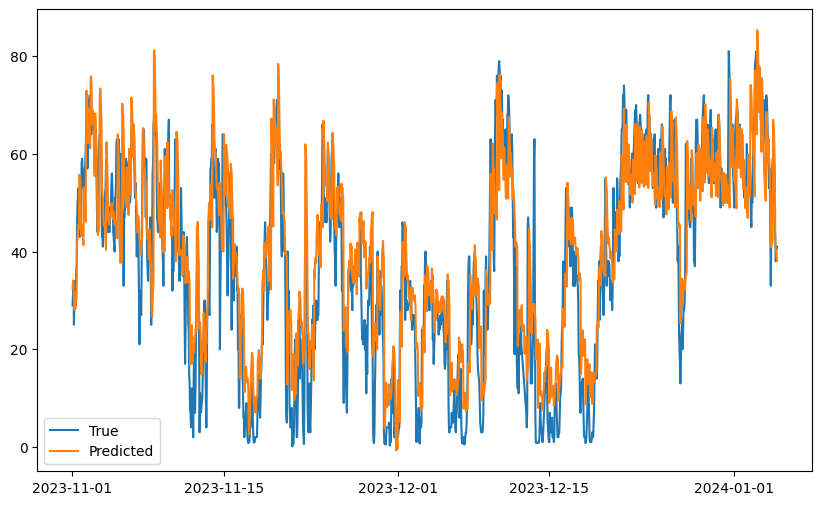

MSE: 111.38233863596565
R2: 0.7568340427600414
RMSE: 10.553783143307696
MAPE: nan


In [156]:
metrics_and_plot(predictions_rod_o3, test_rod_o3['O3'])

In [157]:
series = ['O3','Humidity','Temperature','Windspeed','WindDirection','Precipitation']
lags = 240
steps = 24
model_rod_o3_effect, forecaster_rod_o3_effect,data_rod_effect, train_rod_o3_effect,val_rod_o3_effect,test_rod_o3_effect = build_model(rod_training, series, lags, steps, 4, 128,False)

forecaster_rod_o3_effect, preds_rod_o3_effect = train_model(forecaster_rod_o3_effect,train_rod_o3_effect,24)

Epoch 1/4
127/127 [==============================] - 8s 30ms/step - loss: 0.0391 - val_loss: 0.0659
Epoch 2/4
127/127 [==============================] - 3s 23ms/step - loss: 0.0116 - val_loss: 0.0514
Epoch 3/4
127/127 [==============================] - 3s 24ms/step - loss: 0.0109 - val_loss: 0.0652
Epoch 4/4
127/127 [==============================] - 3s 26ms/step - loss: 0.0106 - val_loss: 0.0742


In [158]:
metrics_rod_o3_effect, predictions_rod_o3_effect = backtesting_evaluation(forecaster_rod_o3_effect,data_rod_effect, '2024-01-09 00:00:00')

Epoch 1/4
137/137 [==============================] - 7s 29ms/step - loss: 0.0099 - val_loss: 0.0681
Epoch 2/4
137/137 [==============================] - 3s 23ms/step - loss: 0.0095 - val_loss: 0.0586
Epoch 3/4
137/137 [==============================] - 4s 26ms/step - loss: 0.0094 - val_loss: 0.0606
Epoch 4/4
137/137 [==============================] - 3s 24ms/step - loss: 0.0092 - val_loss: 0.0609


  0%|          | 0/66 [00:00<?, ?it/s]

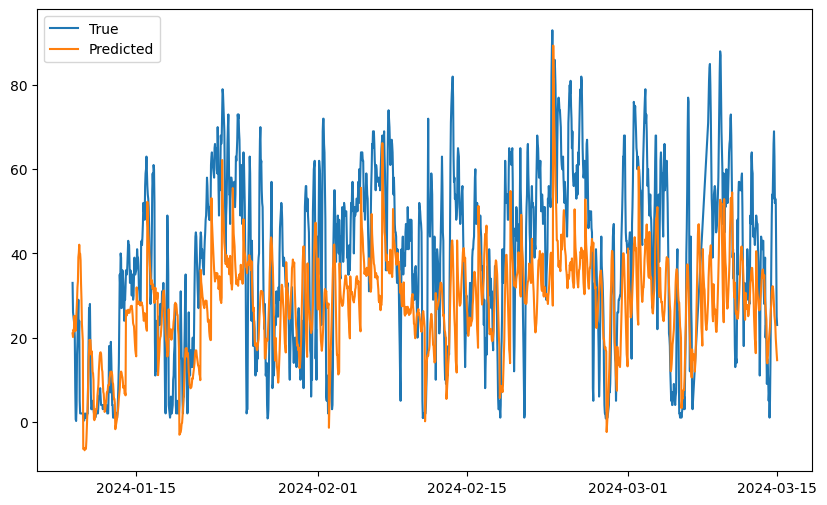

MSE: 390.2719295109903
R2: 0.13053978535658806
RMSE: 19.75530130144793
MAPE: nan


In [159]:
metrics_and_plot(predictions_rod_o3_effect, test_rod_o3_effect['O3'])

In [160]:
effect_measure(predictions_rod_o3_effect, test_rod_o3_effect,'O3')

Mean difference between strike prediction and real observation: -9.199722890089838
Mean percent difference between strike prediction and real observation: 72.74851775137205
Mean difference between strike prediction and real observation GDL: -4.972409976920367
Mean percent difference between strike prediction and real observation GDL: 50.66777694234782
